### Data source:

https://www.kaggle.com/erikbruin/airbnb-amsterdam

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import nltk
import cleantext
from wordcloud import WordCloud

In [2]:
listings = pd.read_csv('./Data/listings.csv')
listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,248,2018-11-28,2.10,1,44
1,3209,"Quiet apt near center, great view",3806,Maartje,NaN,Westerpark,52.390225,4.873924,Entire home/apt,160,4,42,2018-08-29,1.03,1,47
2,20168,100%Centre-Studio 1 Private Floor/Bathroom,59484,Alex,NaN,Centrum-Oost,52.365087,4.893541,Entire home/apt,80,1,233,2018-11-30,2.18,2,198
3,25428,Lovely apt in City Centre (Jordaan),56142,Joan,NaN,Centrum-West,52.373114,4.883668,Entire home/apt,125,14,1,2018-01-21,0.09,2,141
4,27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,NaN,Centrum-West,52.386727,4.892078,Private room,150,2,171,2018-11-25,2.03,1,199


In [3]:
reviews = pd.read_csv('./Data/reviews_details.csv')

reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2818,1191,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...
1,2818,1771,2009-04-24,12798,Alice,Daniel is the most amazing host! His place is ...
2,2818,1989,2009-05-03,11869,Natalja,We had such a great time in Amsterdam. Daniel ...
3,2818,2797,2009-05-18,14064,Enrique,Very professional operation. Room is very clea...
4,2818,3151,2009-05-25,17977,Sherwin,Daniel is highly recommended. He provided all...


### Merge datasets

The reviews and listings are kept in separate data files, so we will have to merge them. We merge them based on listing_id.

In [4]:
#Rename the column in listings from id to listing_id for easier merging
listings = listings.rename({'id' : 'listing_id'}, axis = 1)

df = listings.merge(reviews,
                   how = 'inner',
                   on = 'listing_id')

df.head()

,listing_id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,id,date,reviewer_id,reviewer_name,comments
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,...,248,2018-11-28,2.1,1,44,1191,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...
1,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,...,248,2018-11-28,2.1,1,44,1771,2009-04-24,12798,Alice,Daniel is the most amazing host! His place is ...
2,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,...,248,2018-11-28,2.1,1,44,1989,2009-05-03,11869,Natalja,We had such a great time in Amsterdam. Daniel ...
3,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,...,248,2018-11-28,2.1,1,44,2797,2009-05-18,14064,Enrique,Very professional operation. Room is very clea...
4,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,NaN,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,...,248,2018-11-28,2.1,1,44,3151,2009-05-25,17977,Sherwin,Daniel is highly recommended. He provided all...


# Cleaning data

In [5]:
df.shape

(431830, 21)

In [6]:
#Checking for null values:

df.isnull().sum()

#There are some null values in the comments section (reviews without comments).
#These should be replaced with empty strings.

df['comments'].fillna(value = '', inplace = True)

#The neighbourhood_group column is entirely null values, so we drop it

df.drop(labels = 'neighbourhood_group', axis = 1, inplace = True)

#As for the remaining rows with name and host_name as NA, we drop the entire row since it's only about  ~300 rows in total

df.dropna(axis = 0, inplace = True)

In [7]:
#Check the dataframe after cleaning:

df.isnull().sum()

listing_id                        0
name                              0
host_id                           0
host_name                         0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
id                                0
date                              0
reviewer_id                       0
reviewer_name                     0
comments                          0
dtype: int64

# Seeing common words in each neighborhood

Here we attempt to create wordclouds to visualize the characteristics in each neighborhood.

In [8]:
#Check out how many different neighborhoods are in Amsterdam:

df['neighbourhood'].unique()

neighbourhood_counts = df.groupby('neighbourhood').count()['listing_id'].sort_values()
neighbourhood_counts

neighbourhood
Bijlmer-Oost                               2253
Gaasperdam - Driemond                      2815
Bijlmer-Centrum                            2829
Buitenveldert - Zuidas                     3150
Osdorp                                     3789
Geuzenveld - Slotermeer                    3899
De Aker - Nieuw Sloten                     4349
Noord-Oost                                 5835
Noord-West                                 7455
IJburg - Zeeburgereiland                   8058
Slotervaart                                8237
Watergraafsmeer                            8679
Oud-Noord                                 12382
Oostelijk Havengebied - Indische Buurt    18861
Bos en Lommer                             21004
Oud-Oost                                  21669
Zuid                                      25336
Westerpark                                28463
De Pijp - Rivierenbuurt                   48025
Centrum-Oost                              49537
De Baarsjes - Oud-West    

In [9]:
#There are quite a few neighborhoods, so for this analysis we only take the top and bottom 3

neighbourhoods = list(neighbourhood_counts[0:3].index) + list(neighbourhood_counts[-3:len(neighbourhood_counts)].index)

neighbourhoods

['Bijlmer-Oost',
 'Gaasperdam - Driemond',
 'Bijlmer-Centrum',
 'Centrum-Oost',
 'De Baarsjes - Oud-West',
 'Centrum-West']

In [10]:
%%time
GD_comments = df[df['neighbourhood'] == neighbourhoods[1]]['comments'].sum()

Wall time: 358 ms


In [11]:
%%time
BO_comments = df[df['neighbourhood'] == neighbourhoods[0]]['comments'].sum()

Wall time: 223 ms


In [12]:
%%time
BC_comments = df[df['neighbourhood'] == neighbourhoods[2]]['comments'].sum()

Wall time: 356 ms


In [19]:
%%time
CO_comments = df[df['neighbourhood'] == neighbourhoods[3]]['comments'].sum()

#Why does the time taken incrase by so much?

Wall time: 4min 47s


In [25]:
%%time
DBOW_comments = df[df['neighbourhood'] == neighbourhoods[4]]['comments'].sum()

#8 mins for 67k comments compared to 0.35s for 3k?

Wall time: 9min 28s


In [27]:
%%time
CW_comments = df[df['neighbourhood'] == neighbourhoods[5]]['comments'].sum()

Wall time: 11min 16s


# Removing stopwords and lemmatization

In [28]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import cleantext

In [29]:
%%time
BO_clean = cleantext.clean(text = BO_comments, extra_spaces = True, punct = True, stopwords = True)
GD_clean = cleantext.clean(text = GD_comments, extra_spaces = True, punct = True, stopwords = True) 
BC_clean = cleantext.clean(text = BC_comments, extra_spaces = True, punct = True, stopwords = True) 
CO_clean = cleantext.clean(text = CO_comments, extra_spaces = True, punct = True, stopwords = True) 
DBOW_clean = cleantext.clean(text = DBOW_comments, extra_spaces = True, punct = True, stopwords = True) 
CW_clean = cleantext.clean(text = CW_comments, extra_spaces = True, punct = True, stopwords = True) 

Wall time: 27.7 s


In [30]:
#Lemmatize by reducing each word to the root

text_list = [BO_clean, GD_clean, BC_clean, CO_clean, DBOW_clean, CW_clean]

lemmatizer = WordNetLemmatizer()
lemmatized_text_list = [lemmatizer.lemmatize(text) for text in text_list]

In [31]:
#Create a dictionary with the neighbourhood as keys and the text as values
Neighbourhood_words = dict(zip(neighbourhoods, lemmatized_text_list))

Neighbourhood_words.keys()

dict_keys(['Bijlmer-Oost', 'Gaasperdam - Driemond', 'Bijlmer-Centrum', 'Centrum-Oost', 'De Baarsjes - Oud-West', 'Centrum-West'])

In [32]:
#Check the values are text
Neighbourhood_words['Bijlmer-Oost'][:200]

'Martine greatest host She opened home us couldnt felt welcomed She offered tips went way help us questions able come Its people like Martine prove still amazing people Her home spectacular located cle'

# Creating wordclouds for each neighborhood

### We start with creating a wordcloud for Bijlmer-Oost, the neighbourhood with the least reviews:

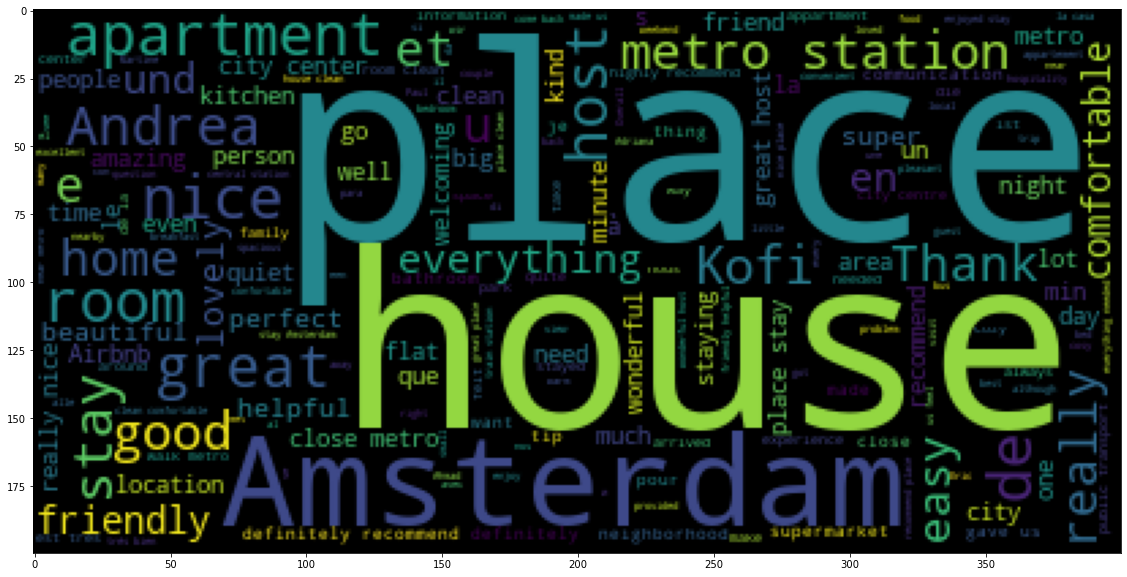

In [33]:
from wordcloud import WordCloud

plt.figure(figsize = (20,10))

wc_BO = WordCloud(background_color = 'black')
wc_BO.generate(Neighbourhood_words['Bijlmer-Oost'])

plt.imshow(wc_BO)

### And one for Centrum-West, the neighbourhood with the most reviews:

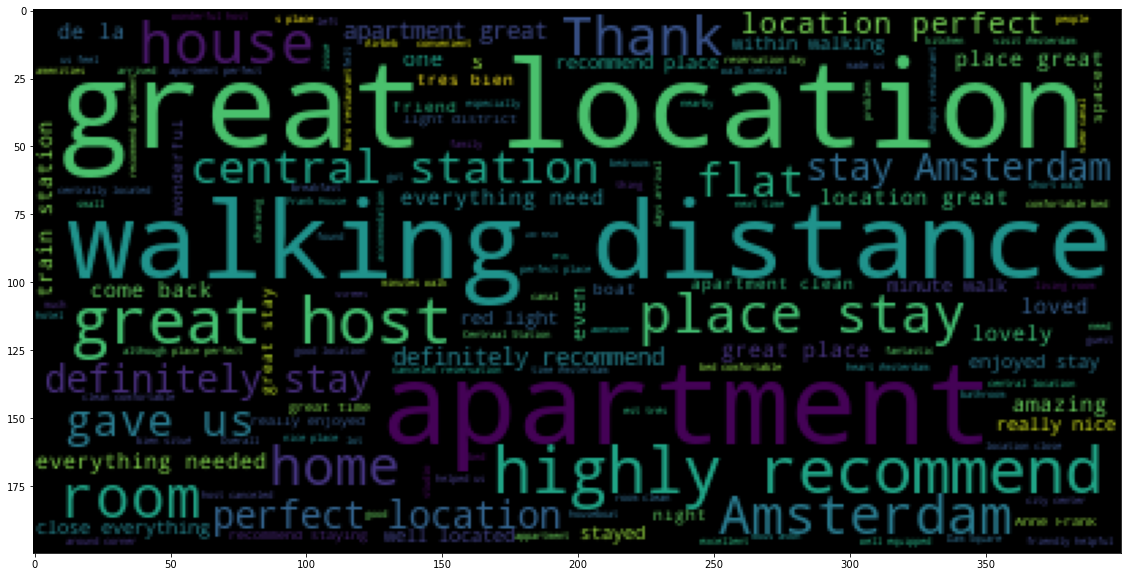

In [34]:
wc_CW = WordCloud(background_color = 'black')
wc_CW.generate(Neighbourhood_words['Centrum-West'])

plt.figure(figsize = (20,10))

plt.imshow(wc_CW)

It seems like in Centrum-West there are more apartments, compared to more houses in Bijlmer-Oost. There also seem to be more things within walking distance, and people mention the location more in the reviews. 

In Bijlmer-Oost there are more descriptive words like 'beautiful' and 'lovely' about the residence rather than the location of the stay.

### Creating a recommendation engine for which neighbourhood to stay at

Here we attempt to create a service that can recommend to people which neighborhood they should stay in when visiting Amsterdam. The input should be a theoretical review for the perfect place you want. Then a classification model can be trained to recommend a 'topic' based on your review, which is the neighbourhood.

 

# Converting the text to word vectors:

In [35]:
neighbourhoods

['Bijlmer-Oost',
 'Gaasperdam - Driemond',
 'Bijlmer-Centrum',
 'Centrum-Oost',
 'De Baarsjes - Oud-West',
 'Centrum-West']

In [36]:
#We only take the busiest 3 and quietest 3 neighbourhoods for our model

df = df[df['neighbourhood'].isin(neighbourhoods)]

In [37]:
#For the word vectors we will use the embeddings done by spacy

import spacy
#!python -m spacy download en_core_web_md

In [38]:
spacymodel = spacy.load('en_core_web_md')

In [39]:
%%time

X = df['comments'].apply(cleantext.clean, punct = True, stopwords = True, extra_spaces = True)

Wall time: 1min 4s


In [40]:
X

290       The location Sashas BB makes ideal short Amste...
291       The room much smaller picture filled Mosquitos...
292       The place much better I thought Very nice room...
293       La camera non era quella delle foto nel comple...
294       Alex wonderful host nice The room cozy great y...
                                ...                        
431821    The host canceled reservation 27 days arrival ...
431822    The host canceled reservation 12 days arrival ...
431823              Most wonderful hospitality friendliness
431825    The host canceled reservation day arrival This...
431828    I loved house It truly incredible Tie en Taia ...
Name: comments, Length: 202349, dtype: object

In [41]:
y = df['neighbourhood']

In [42]:
%%time

X_docs = X.apply(spacymodel)

Wall time: 29min 14s


In [43]:
#The model converts it into a doc type

X_docs[290]

The location Sashas BB makes ideal short Amsterdam visits everything might want see walkable We stayed smallest room building ok one night spent Our room neat clean bathroom If travel luggage want stay longer make sure book bigger room Unfortunately site quite clear choose room youll staying

In [44]:
type(X_docs[290])

spacy.tokens.doc.Doc

In [45]:
#We can see the review expressed as a word vector:

X_docs[290].vector[:3]

array([ 0.1551877 ,  0.12934722, -0.22271399], dtype=float32)

In [46]:
%%time

#We create a list of the X_train in word vector form:

X_wordvecs = [doc.vector for doc in X_docs]

Wall time: 30.2 s


# Training a classifier model:

In [47]:
#Split our data into training and testing data:

from sklearn.model_selection import train_test_split

X_train_wordvecs, X_test_wordvecs, y_train, y_test = train_test_split(X_wordvecs, y, test_size=0.33, random_state=42)

In [48]:
len(y_test)

66776

In [49]:
%%time
#Now we can train a model to classify the reviews based on the mean word vectors

from sklearn.svm import SVC

SVM_classifier = SVC(kernel = 'linear') #Linear kernels work better for classifying text

SVM_classifier.fit(X_train_wordvecs, y_train)

Wall time: 3h 22min 22s


SVC(kernel='linear')

In [ ]:
'''
#Saving the model:

with open('SVC_model.pkl', 'wb') as file:
    pickle.dump(SVM_classifier, file)
'''

#Load the model:
with open('./Models/SVC_model.pkl', 'rb') as file:
    SVM_classifier = pickle.load(file)

In [53]:
%%time
#Generate some predictions


predictions = SVM_classifier.predict(X_test_wordvecs)


In [88]:
#Evaluate the model:

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [56]:
#Let's evaluate our model to see the accuracy:

accuracy_score(y_test, predictions)

0.48993650413322154

In [58]:
#Get a classification report

print(classification_report(y_test,predictions))

                        precision    recall  f1-score   support

       Bijlmer-Centrum       0.65      0.05      0.09       968
          Bijlmer-Oost       0.37      0.04      0.07       717
          Centrum-Oost       0.43      0.02      0.05     16296
          Centrum-West       0.49      0.73      0.59     25702
De Baarsjes - Oud-West       0.50      0.60      0.54     22172
 Gaasperdam - Driemond       0.47      0.02      0.05       921

              accuracy                           0.49     66776
             macro avg       0.48      0.25      0.23     66776
          weighted avg       0.48      0.49      0.42     66776



In [90]:
#See the confusion matrix for the predictions

print(confusion_matrix(y_test,predictions))

[[   48    16    34   395   470     5]
 [    8    26    16   215   441    11]
 [    6    10   393 10321  5562     4]
 [    0     4   241 18822  6634     1]
 [    3     2   185  8573 13405     4]
 [    9    13    41   307   529    22]]


In [91]:
#Recap the neighbourhoods we're predicting on:
neighbourhoods

['Bijlmer-Oost',
 'Gaasperdam - Driemond',
 'Bijlmer-Centrum',
 'Centrum-Oost',
 'De Baarsjes - Oud-West',
 'Centrum-West']

The model performs extremely poorly in some categories but decently in the Centrum-West and DBOW neighbourhoods! For the BC, BO and GD neighborhoods, it may be due to a small sample size. For the Centrum-Oost neighbourhood, it could be that the reviews don't have too much of a difference from the Centrum-West neighbourhood. 

However the model performs reasonably well in classifying the Centrum-West and De Baarsjes - Oud-West neighbourhoods. 

Here I will just go ahead and attempt to make the recommendation engine, hopefully in the future it can utilize a better model..

# Creating a recommendation engine

In [86]:
def recommend(example_review):
    '''
    This function recommends a neighbourhood suitable for your AirBnb stay in Amsterdam.
    The input can be an example review of your preferred place, or some descriptions or keywords of it.
    '''
    import spacy
    
    #First we convert the input into word vectors
    spacymodel = spacy.load('en_core_web_md')
    docs = spacymodel(example_review)
    wordvec = docs.vector
    
    #Import the previously trained model
    with open('./Models/SVC_model.pkl', 'rb') as file:
        SVC_classifier = pickle.load(file)
    
    
    #Generate the prediction
    prediction = SVC_classifier.predict(np.reshape(wordvec, (-1,300)))
    
    
    print('The recommended neighbourhood for your stay is {}'.format(prediction))
    

In [83]:
#Try the function for a countryside-esque place

recommend('I want a quiet place in the countryside with no people')

(300,)
The recommended neighbourhood for your stay is ['De Baarsjes - Oud-West']


In [84]:
#Try the function for a city-preferring person

recommend('Somewhere with a great location, walking distance from stations')

(300,)
The recommended neighbourhood for your stay is ['Centrum-West']


In [87]:
recommend('Farm animals, flowers and a nice garden')

The recommended neighbourhood for your stay is ['De Baarsjes - Oud-West']
